In [2]:
import pynr as nr
import ringdown_fits as rdf
import matplotlib.pyplot as plt
import numpy as np
import qnm

### Some useful functions

In [3]:
def QNM_spectrum(l,m,n,mass,spin):
    """ It computes the RD frequencies and damping times in NR units.
    """  
    omegas_new=modes_spec[-2,l,m,n](spin)[0]
    w_m_a = (np.real(omegas_new))/mass
    tau_m_a=-1/(np.imag(omegas_new))*mass

    return (np.array([w_m_a]), np.array([tau_m_a]))

def QNM_spectrum_w(l,m,n,mass,spin):
    """ It computes the RD frequencies and damping times in NR units.
    """  
    omegas_new=modes_spec[-2,l,m,n](spin)[0]/mass

    return omegas_new

def QNM_spectrum_re_im(l,m,n,mass,spin):
    """ It computes the RD frequencies and damping times in NR units.
    """  
    omegas_new=modes_spec[-2,l,m,n](spin)[0]
    w_re = (np.real(omegas_new))/mass
    w_im = (np.imag(omegas_new))/mass

    return w_re+1j*w_im

def delta_omega(omega_fit, omega_target):
    
    r_fit = np.real(omega_fit)
    i_fit = np.imag(omega_fit)
    
    r_target = np.real(omega_target)
    i_target = np.imag(omega_target)
    
    return np.sqrt(((r_fit-r_target)/r_target)**2 + ((i_fit-i_target)/i_target)**2)

### Load the qnm spectra

In [4]:
s, l, m = [(-2,-2,-2,-2),(2,4,4,2),(0,0,4,2)]
mode_list = [(s[i], l[i], m[i], n) for n in np.arange(0,8) for i in range(len(m))]
modes_spec = { ind : qnm.modes_cache(*ind) for ind in mode_list }

### Download the NR SXS data with pynr

In [5]:
h_modes = nr.nr_waveform(code='SXS',
                       pycbc_format=False,
    download_Q = True,
    tag = 'SXS:BBH:0305',
    extrapolation_order = 2,
    mass = 100,
    resolution_level = -1,
    modes  = [[2,2]],
    modes_combined = False,
    delta_t = 1/4096,
    tapering = False,
    RD = True,
    zero_align = True,
    NRUnits = True,
    toffset = 0)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer


/work/francisco.jimenez/ecc_env/lib/python3.7/site-packages/sxs/waveforms/nrar.py:173: UserWarning: 
Could not find root group as `h5_group` or as `extrapolation_order`; returning all groups
  warnings.warn(warning)


/work/francisco.jimenez/ecc_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


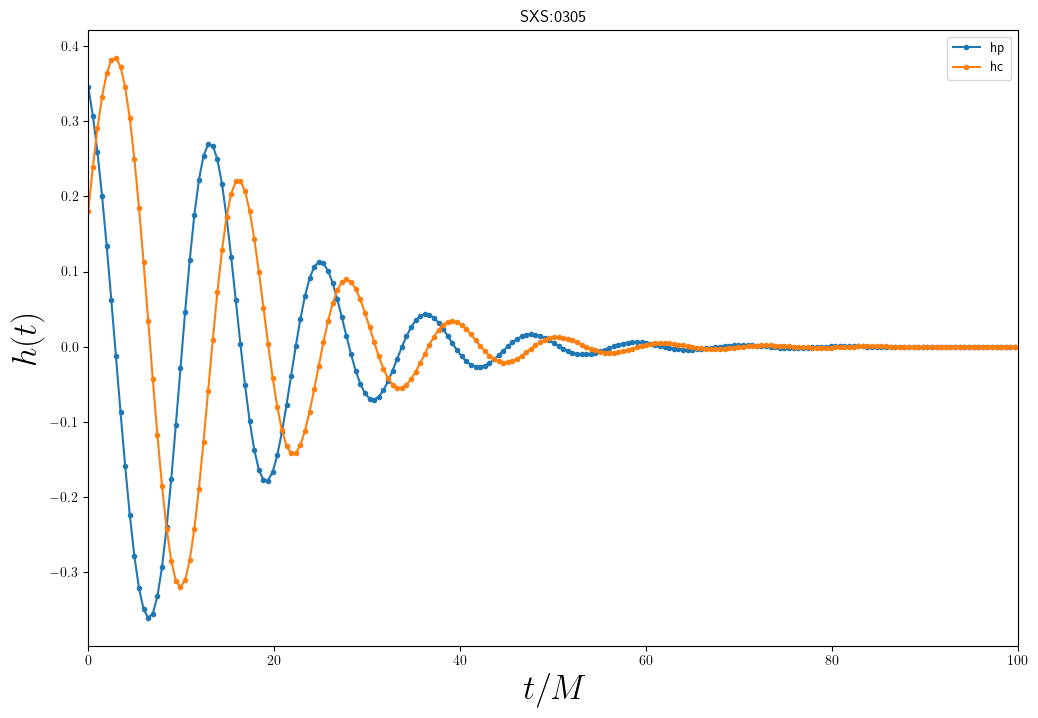

In [6]:
times = h_modes[0][:,0]
data = h_modes[0][:,1]

plt.figure(figsize=(12, 8))
plt.plot(times, data, linestyle='-', marker='o', markersize=3,label = 'hp')
plt.plot(times, data.imag, linestyle='-', marker='o', markersize=3,label = 'hc')
plt.legend()
plt.xlabel('$t/M$', fontsize=25)
plt.ylabel('$h(t)$', fontsize=25)
plt.title("SXS:0305")
plt.xlim(0,100)
plt.show()

### Fit a ringdown model for n = 0

#### I use a model that fits A0, phi0, alpha0 and beta0 for $A_0 e^{\iota \phi_0} e^{-t/\tau_0 (1+\beta_0)} e^{\iota w_0}$.
Initial parameters are for A0, phi0, alpha0 and beta0

In [7]:
qnmspec=np.array([QNM_spectrum(2,2,n,0.952,0.692) for n in range(8)]) 
args = {'qnms': qnmspec, 'real': False}

fitres=rdf.fit_qnm(h_modes[0],[0.1,0,0,0],t0 = 20,linear = False, model = 'w-tau-a-b-last',
               min_method = 'Nelder-Mead', tol=1e-8,bounds = None,**args)
fitres

array([-1.90687604, -1.35150088,  0.22266358, -0.26346065])

In [8]:
fit_model = rdf.rd_model_wtau_a_b_last(fitres,times = times,**args)

/work/francisco.jimenez/ecc_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


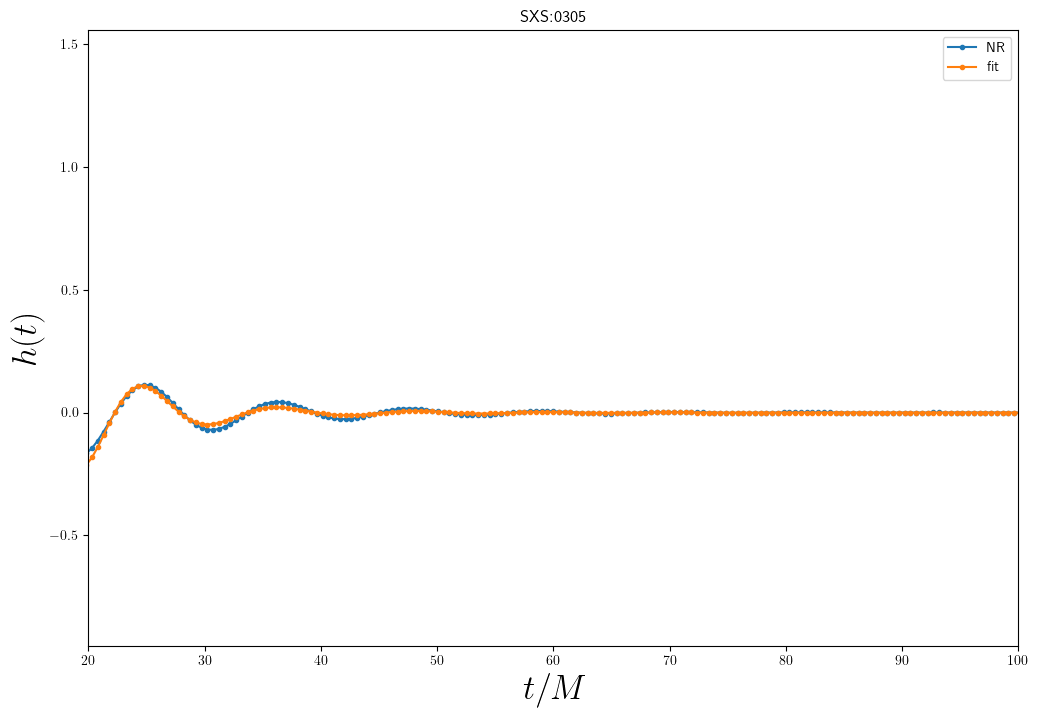

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(times, data, linestyle='-', marker='o', markersize=3,label = 'NR')
plt.plot(times, fit_model, linestyle='-', marker='o', markersize=3,label = 'fit')

plt.legend()
plt.xlabel('$t/M$', fontsize=25)
plt.ylabel('$h(t)$', fontsize=25)
plt.title("SXS:0305")
plt.xlim(20,100)
plt.show()

### Now fit an n = 7 ringdown model

In [10]:
args = {'qnms': qnmspec, 'real': False}
frequencies = np.array([QNM_spectrum_re_im(2,2,n,0.952,0.692) for n in range(8)])
#initial = np.insert(frequencies,[8],np.array([1]),axis=0)

fitres=rdf.fit_qnm(np.conjugate(h_modes[0]),frequencies,t0 = 0,linear = True, model = 'w-tau-fixed',
               min_method = 'Nelder-Mead', tol=1e-8,bounds = None,**args)

#### I use a model that fits A0, phi0 for $\sum_n A_n e^{\iota \phi_n} e^{-t/\tau_n} e^{\iota w_n}$.
Initial parameters are now $\tau_n$ and $w_n$ 

In [11]:
pars = np.hstack((abs(fitres),np.angle(fitres)))
fit_model = rdf.rd_model_wtau_fixed(pars,times = times,**args)

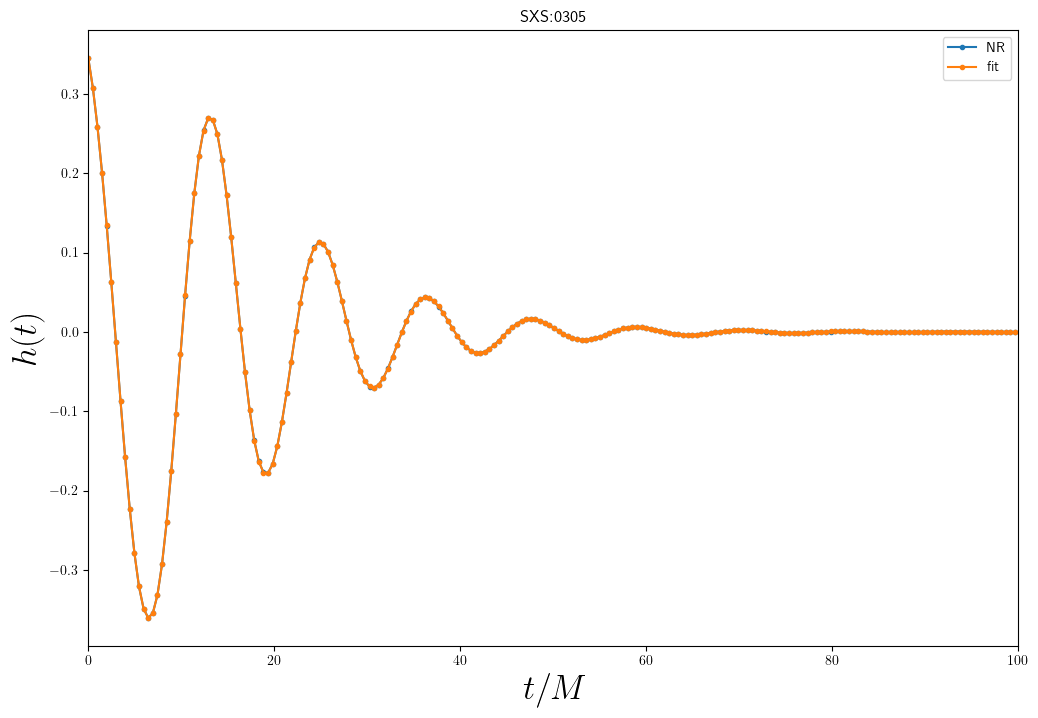

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(times, data, linestyle='-', marker='o', markersize=3,label = 'NR')
plt.plot(times, fit_model, linestyle='-', marker='o', markersize=3,label = 'fit')
plt.legend()
plt.xlabel('$t/M$', fontsize=25)
plt.ylabel('$h(t)$', fontsize=25)
plt.title("SXS:0305")
plt.xlim(0,100)
plt.show()

### Find the quadratic modes

In [13]:
h_modes = nr.nr_waveform(code='SXS',
                       pycbc_format=False,
    download_Q = True,
    tag = 'SXS:BBH:0305',
    extrapolation_order = 2,
    mass = 100,
    resolution_level = -1,
    modes  = [[4,4]],
    modes_combined = False,
    delta_t = 1/4096,
    tapering = False,
    RD = True,
    zero_align = True,
    NRUnits = True,
    toffset = 0)

/work/francisco.jimenez/ecc_env/lib/python3.7/site-packages/sxs/waveforms/nrar.py:173: UserWarning: 
Could not find root group as `h5_group` or as `extrapolation_order`; returning all groups
  warnings.warn(warning)


Fit for the quadratic modes and per time t

In [14]:
gw_nr_rd_reim=h_modes[0]

dw=[]
mode = QNM_spectrum_w(4,4,0,0.952,0.692) 
for i in range(10,35,1):
    omega_fit = rdf.fit_qnm_varying_f(np.conjugate(gw_nr_rd_reim),mode,t0 = i, ini_freqs = [1.1,-0.20])[-2:]
    omega_fit = omega_fit[0] + 1j*omega_fit[1]

    omega_target = QNM_spectrum_w(2,2,0,0.952,0.692)*2
    dw.append(delta_omega(omega_fit, omega_target))

Plot the difference between the theoretical expected frequency and the one obtained by fitting

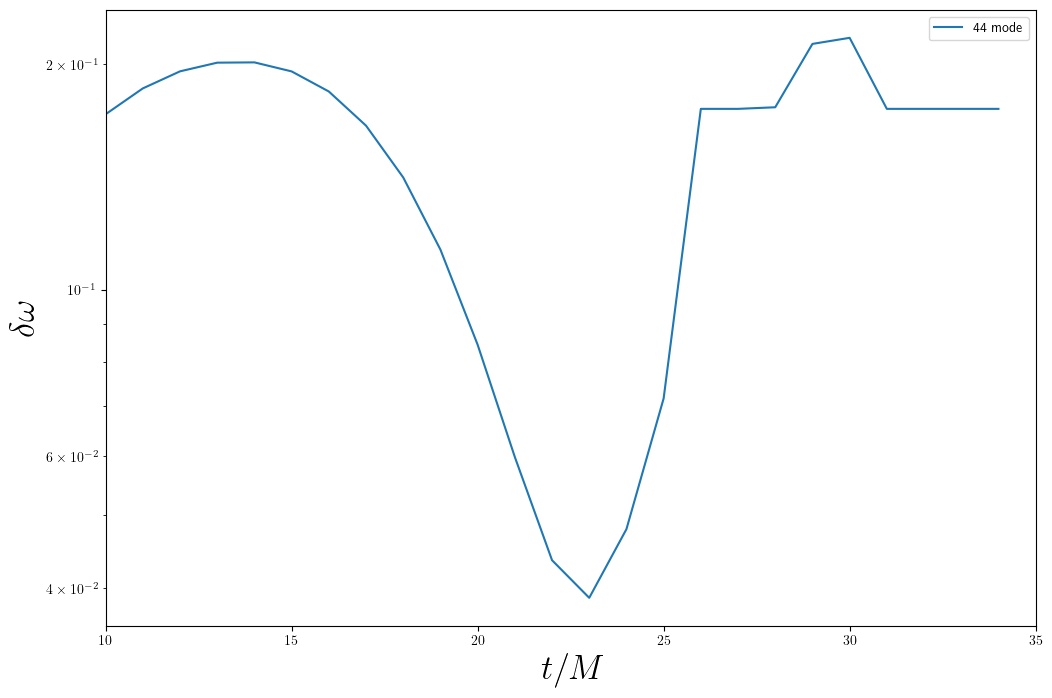

In [15]:
plt.figure(figsize=(12, 8))
times=np.linspace(10,34,25)
plt.plot(times,dw,label='44 mode')
plt.xlabel(r'$t/M$', fontsize = 25)
plt.ylabel(r'$\delta \omega$', fontsize = 25)
plt.yscale("log")
plt.xlim(10,35)
plt.legend()
plt.show()

In [16]:
time_of_minimum = 24
mode = QNM_spectrum_w(4,4,0,0.952,0.692) 
omega_fit_at_min = rdf.fit_qnm_varying_f(np.conjugate(gw_nr_rd_reim),mode,t0 = time_of_minimum, ini_freqs = [1.1,-0.20])[-2:]

frequencies = np.array([QNM_spectrum_re_im(4,4,n,0.952,0.692) for n in range(2)])
omega_fit_at_min,delta_omega(omega_fit_at_min[0]+1j*omega_fit_at_min[1], omega_target)

(array([ 1.10261183, -0.17840669]), 0.04792688376389117)

In [17]:
qnmspec=np.array([QNM_spectrum(4,4,n,0.952,0.692) for n in range(2)]) 
args = {'qnms': qnmspec, 'real': False}

In [18]:
alpha_vals = np.linspace(-1,1,100)
beta_vals = np.linspace(-0.9,1,100)
mismatch = []

for alpha in alpha_vals:
    for beta in beta_vals:
        freqs = np.hstack((QNM_spectrum_w(4,4,0,0.952,0.692),omega_fit_at_min[0]*(1+alpha)+1j*omega_fit_at_min[1]*(1+beta)))
        qnmspec[1]= [[freqs[1].real],[-1/freqs[1].imag]]
        args = {'qnms': qnmspec, 'real': False}  
        fit   =  rdf.fit_qnm(np.conjugate(h_modes[0]),freqs,t0 = time_of_minimum,linear = True)
        pars = np.hstack((abs(fit),np.angle(fit)))
        fit_model = rdf.rd_model_wtau_fixed(pars,times = h_modes[0][:,0],**args)
        mm = rdf.mismatch_t(np.conjugate(h_modes[0]),np.stack((h_modes[0][:,0],fit_model)).T,time_of_minimum,time_of_minimum+100)
        mismatch.append([alpha,beta,1-mm])

mismatch = np.array(mismatch)

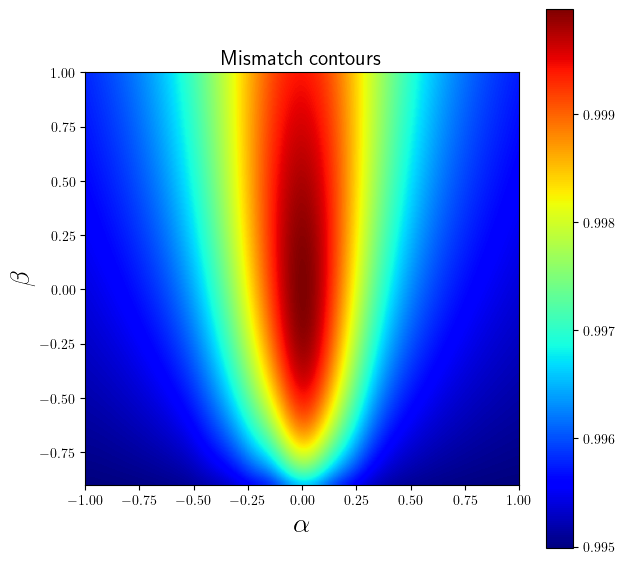

In [19]:
x = mismatch[:,0]
y = mismatch[:,1]
z = mismatch[:,2]
 
x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)
Z=z.reshape(len(x),len(y))
Z=np.transpose(Z)
data = Z
plt.figure(figsize=(7,7), dpi=100)
#plt.contour(X, Y, Z, 7, linewidths = 0.5, colors = 'k')
plt.imshow( data , cmap = 'jet' , interpolation = 'gaussian' , origin='lower',\
           aspect='equal',  extent = [min(x), max(x), min(y), max(y)] )  
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
plt.title( "Mismatch contours", fontsize=15 )
plt.xlabel(r"$\alpha$", fontsize=20)
plt.ylabel(r"$\beta$", fontsize=20)
plt.colorbar()
plt.show()

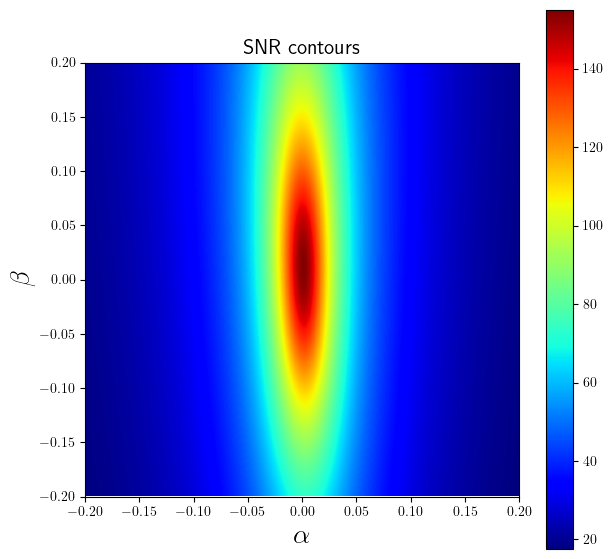

In [216]:
x = mismatch[:,0]
y = mismatch[:,1]
z = np.sqrt(1/(2*(1-mismatch[:,2])))
 
x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)
Z=z.reshape(len(x),len(y))
Z=np.transpose(Z)
data = Z
plt.figure(figsize=(7,7), dpi=100)
#plt.contour(X, Y, Z, 7, linewidths = 0.5, colors = 'k')
plt.imshow( data , cmap = 'jet' , interpolation = 'gaussian' , origin='lower',\
           aspect='equal',  extent = [min(x), max(x), min(y), max(y)] )  
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
plt.title( "SNR contours", fontsize=15 )
plt.xlabel(r"$\alpha$", fontsize=20)
plt.ylabel(r"$\beta$", fontsize=20)
plt.colorbar()
plt.show()